In [1]:
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.optimize import minimize
from tqdm import tqdm
import HammerProj as hp
import numba as nb
import KetSugar as ks
import MaxLik as ml

MaxLik: Numba Allowed: True => use cycle-based K-vector construction


In [2]:
def expectation_value(Ket, M):
    """
    Expectation value <bra|M|ket>.
    """
    return (Ket.T.conjugate() @ M @ Ket)[0,0]
    
@nb.njit()
def get_pis(alpha):
    phases = np.array([0, np.pi, np.pi/2, np.pi*3/2])*(1+alpha)
    LO = np.array([[1], [0]], dtype=np.complex128)
    HI = np.array([[0], [1]], dtype=np.complex128)
    # Plus = (LO + HI*np.exp(1j*phases[0]))*(2**-.5)
    # Minus = (LO + HI*np.exp(1j*phases[1]))*(2**-.5)
    # RPlu = (LO + np.exp(1j*phases[2])*HI)*(2**-.5)
    # RMin = (LO + np.exp(1j*phases[3])*HI)*(2**-.5)
    pis = np.zeros((6,2,1), dtype=np.complex128)
    pis[0] = LO
    pis[1] = HI
    pis[2] = (LO + HI*np.exp(1j*phases[0]))*(2**-.5)
    pis[3] = (LO + HI*np.exp(1j*phases[1]))*(2**-.5)
    pis[4] = (LO + HI*np.exp(1j*phases[2]))*(2**-.5)
    pis[5] = (LO + HI*np.exp(1j*phases[3]))*(2**-.5)
    return pis

def get_assumed_rpv(alpha):    
    proj_kets = get_pis(alpha)
    return np.array([ket @ ket.T.conjugate() for ket in proj_kets])

def multipur(rhos):
    n, d, d = rhos.shape
    vec_a = rhos.conj().reshape((n, d*d))
    vec_b = rhos.reshape((n, d*d))
    #equivalent to trace(rho @ rho) for rho in rhos
    return np.sum((vec_a*vec_b).real, axis=1)


ML_ITERS = 1000
ML_THR = 1e-12

def map_tomograms(tomos, pis):
    return np.array([ml.Reconstruct(t, pis, ML_ITERS, ML_THR, RhoPiVect = True, Renorm = True) for t in tomos])


def speculate(data, alpha):
    pis = get_assumed_rpv(alpha)
    rhos = map_tomograms(data, pis)
    return rhos


In [3]:


def BlochKet(theta, phi):
    """
    Return a qubit column-vector with Bloch sphere coordinates theta, phi.
    theta - lattitude measured from |0> on Bloch sphere
    phi - longitude measured from |+> on Bloch sphere (phase)
    """
    return np.array([[np.cos(theta/2)], [np.sin(theta/2)*np.exp(1j*phi)]], dtype=complex)

def hammer_map(rho):
    """
    Map largest eigenstate of the density matrix to Hammer-projected surface of the Bloch sphere.
    """
    return hp.Hammer(*hp.BlochToGeo(*hp.RhoToBloch2(rho)), wrapback=True)

def get_tomograms(alpha, probes_rho):
    gt_pis = get_pis(alpha)
    probes_tomo = np.array([np.array([expectation_value(pi, r).real + 1e-6 for pi in gt_pis]) for r in probes_rho])+1e-3
    return probes_tomo

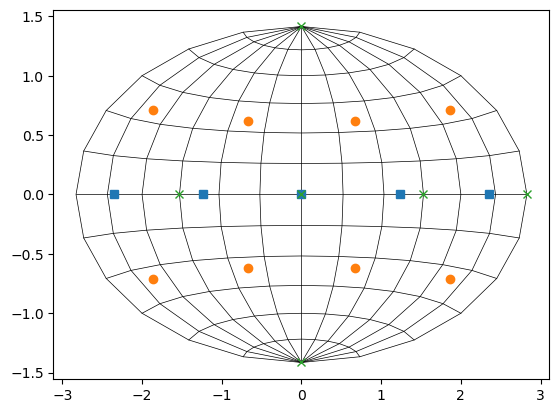

In [4]:
#Show example 1

thetas = [np.pi/2]
phis = np.linspace(0, 2*np.pi, 6)[0:-1]
probes_ket_1 = [BlochKet(theta, phi) for theta, phi in itertools.product(thetas, phis)]
probes_rho_1 = np.array([ket @ ket.T.conj() for ket in probes_ket_1])

# phis = np.linspace(0, 2*np.pi, 6) + np.pi/8
# thetas = [95*np.pi/180.]
# # probes_coords = list(itertools.product(thetas, phis))
# probes_coords_2 = list(zip(np.linspace(0,np.pi-np.pi/16,5), np.linspace(0,np.pi,5)))
# probes_coords_2.append((np.pi/2, 0))
probes_coords_2 = np.load('probes_samplings.npz')['n8']

probes_ket_2 = [BlochKet(theta, phi) for theta, phi in probes_coords_2]
probes_rho_2 = np.array([ket @ ket.T.conj() for ket in probes_ket_2])

probes_coords_3 = np.load('probes_samplings.npz')['n6']
probes_ket_3 = [BlochKet(theta, phi) for theta, phi in probes_coords_3]
probes_rho_3 = np.array([ket @ ket.T.conj() for ket in probes_ket_3])

cycle = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig, ax = plt.subplots(1,1)
hp.PlotHammerGrid(ax, 13, 13)
hp.PlotHammerKets(ax, probes_ket_1, fmt='s', clr=cycle[0])
hp.PlotHammerKets(ax, probes_ket_2, fmt='o', clr=cycle[1])
hp.PlotHammerKets(ax, probes_ket_3, fmt='x', clr=cycle[2])




In [5]:
probes_rho_3

array([[[ 1.00000000e+00+0.000000e+00j,  0.00000000e+00+0.000000e+00j],
        [ 0.00000000e+00+0.000000e+00j,  0.00000000e+00+0.000000e+00j]],

       [[ 5.00000000e-01+0.000000e+00j,  5.00000000e-01+0.000000e+00j],
        [ 5.00000000e-01+0.000000e+00j,  5.00000000e-01+0.000000e+00j]],

       [[ 5.00000000e-01+0.000000e+00j,  3.06161700e-17-5.000000e-01j],
        [ 3.06161700e-17+5.000000e-01j,  5.00000000e-01+0.000000e+00j]],

       [[ 5.00000000e-01+0.000000e+00j, -5.00000000e-01-6.123234e-17j],
        [-5.00000000e-01+6.123234e-17j,  5.00000000e-01+0.000000e+00j]],

       [[ 5.00000000e-01+0.000000e+00j,  3.06161700e-17+5.000000e-01j],
        [ 3.06161700e-17-5.000000e-01j,  5.00000000e-01+0.000000e+00j]],

       [[ 3.74939946e-33+0.000000e+00j,  6.12323400e-17+0.000000e+00j],
        [ 6.12323400e-17+0.000000e+00j,  1.00000000e+00+0.000000e+00j]]])

In [6]:
len(probes_rho_1), len(probes_rho_2), len(probes_rho_3)

(5, 8, 6)

In [7]:
# Compute and store results for all alphas and probe choices
alphas = np.array(sorted(list(np.linspace(-0.1, 0.1, 101)) + [-0.075, -0.025, 0, 0.025, 0.075]))
costs1_arr = np.zeros((5, len(alphas)))
costs2_arr = np.zeros((5, len(alphas)))
costs3_arr = np.zeros((5, len(alphas)))
alpha_trues = [-0.075, -0.025, 0.025, 0.075]

for i, alpha_true in enumerate(alpha_trues):
    tomos1 = get_tomograms(alpha_true, probes_rho_1)
    tomos2 = get_tomograms(alpha_true, probes_rho_2)
    tomos3 = get_tomograms(alpha_true, probes_rho_3)
    def cost(alpha, tomos):
        pis = get_assumed_rpv(alpha)
        rhos = map_tomograms(tomos, pis)
        purs = multipur(rhos)
        return np.ptp(purs)
    costs1_arr[i] = np.array([cost(a, tomos1) for a in tqdm(alphas)])
    costs2_arr[i] = np.array([cost(a, tomos2) for a in tqdm(alphas)])
    costs3_arr[i] = np.array([cost(a, tomos3) for a in tqdm(alphas)])


100%|██████████| 106/106 [00:00<00:00, 264.03it/s]


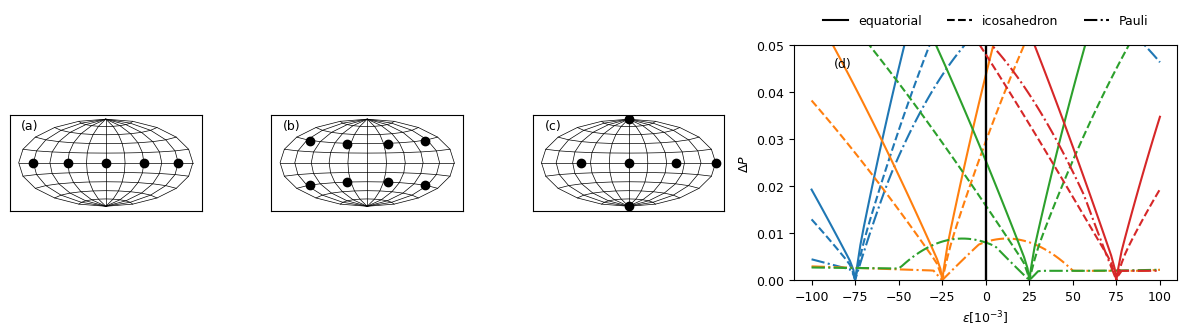

In [8]:
from matplotlib.lines import Line2D

%matplotlib inline
# Produce plot for paper
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (3.5, 3.5)

# gridspec_kw = {'width_ratios' : [1,1,1,0.05]}
# Plotting
fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), gridspec_kw={'width_ratios': [1, 1, 1, 2]})

# Left plot placeholder (empty or for future use)
for i, kets in enumerate((probes_ket_1, probes_ket_2, probes_ket_3)):
    ax = axs[i]    
    ax.tick_params(axis="both", length=0, labelbottom=False, labelleft=False)
    hp.PlotHammerGrid(ax, 11, 11)
    hp.PlotHammerKets(ax, kets, fmt='o', clr='k')


# Right plot: main plot
ax = axs[3]
xscale = 1000
for i, alpha_true in enumerate(alpha_trues):
    ax.vlines([alpha_true], 0, 0.05, colors='k')
    if i == 0:
        labels = ('equatorial', 'icosahedron', 'Pauli')
    else:
        labels = (None, None, None)
    ax.plot(alphas*xscale, costs1_arr[i], '-', c=cycle[i], label=labels[0])
    ax.plot(alphas*xscale, costs2_arr[i], '--', c=cycle[i], label=labels[1])
    ax.plot(alphas*xscale, costs3_arr[i], '-.', c=cycle[i], label=labels[2])

# Add panel labels (a)-(d)
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for idx, ax in enumerate(axs):
    ax.text(0.15, 0.95, panel_labels[idx], transform=ax.transAxes, va='top', ha='right')


for i in range(3):
    axs[i].set_aspect(1)

custom_lines = [
    Line2D([0], [0], color='k', linestyle='-', label='equatorial'),
    Line2D([0], [0], color='k', linestyle='--', label='icosahedron'),
    Line2D([0], [0], color='k', linestyle='-.', label='Pauli')
]
ax.legend(handles=custom_lines, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False)
ax.set_ylim(0, 0.05)
ax.set_xlabel('$\\epsilon [10^{-3}]$')
ax.set_ylabel('$\Delta P$')
plt.tight_layout()
plt.show()

In [14]:
%matplotlib qt
from matplotlib.lines import Line2D
from matplotlib import gridspec

# Produce plot for paper
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (3.5, 3.5)

fig = plt.figure(figsize=(5, 2))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1.6], height_ratios=[1, 1, 1], wspace=0.3)

axs = [plt.subplot(gs[i, 0]) for i in range(3)]
axs.append(plt.subplot(gs[:, 1]))

for i, kets in enumerate((probes_ket_1, probes_ket_2, probes_ket_3)):
    ax = axs[i]    
    ax.tick_params(axis="both", length=0, labelbottom=False, labelleft=False)
    hp.PlotHammerGrid(ax, 11, 11)
    hp.PlotHammerKets(ax, kets, fmt='.', clr='r')

ax = axs[3]
xscale = 100
yscale = 100
for i, alpha_true in enumerate(alpha_trues):
    if i == 0:
        labels = ('equatorial', 'icosahedron', 'Pauli')
    else:
        labels = (None, None, None)
    ax.plot(alphas*xscale, costs1_arr[i]*yscale, '-', c=cycle[i], label=labels[0])
    ax.plot(alphas*xscale, costs2_arr[i]*yscale, '--', c=cycle[i], label=labels[1])
    ax.plot(alphas*xscale, costs3_arr[i]*yscale, '-.', c=cycle[i], label=labels[2])
    ax.vlines([alpha_true*xscale], 0, 0.05*yscale, colors='k', lw=0.75)

# Add panel labels (a)-(d)
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for idx, ax in enumerate(axs):
    if idx != 3:
        ax.text(0.2, 0.95, panel_labels[idx], transform=ax.transAxes, va='top', ha='right')
    else:
        ax.text(0.15, 0.95, panel_labels[idx], transform=ax.transAxes, va='top', ha='right')
# axs[-1].text(0.15, 0.95, panel_labels[-1], transform=ax.transAxes, va='top', ha='right')


for i in range(3):
    axs[i].set_aspect(1)

custom_lines = [
    Line2D([0], [0], color='k', linestyle='-', label='a'),
    Line2D([0], [0], color='k', linestyle='--', label='b'),
    Line2D([0], [0], color='k', linestyle='-.', label='c')
]
ax.legend(handles=custom_lines, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False)
ax.set_ylim(0, 2)
ax.set_xlabel("$\\epsilon'$ [\%]")
ax.set_ylabel('$\Delta P$ [\%]')
plt.subplots_adjust(top=0.88,
bottom=0.2,
left=0.02,
right=0.96,
hspace=0.08,
wspace=0.175)
plt.show()